In [2]:

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp 
from scipy import optimize
from scipy.linalg import toeplitz
from numpy import fft 
from core.core import *
from util.detector import * 
from util.estimator import * 
from util.modem import * 

import random
import os 

### The Maximum Likelihood detection

In [3]:
def ml(y_re, H_re, symbol_space, snr_dB):
    """
    Maximum Likelihood detection for KxN mu-MIMO channel (uses Gaussian distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x_shape)
    return x_hat_ML 

In [412]:

K = 4   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = 10 # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, y):
    """
    Real representation of complex matrix \n
    \t x = [x_r + j x_i] --->  x_re = [x_re x_im] \n
    \t H_re = \n \t \t[H_real, -H_imag \n
        \t H_imag, H_real]\n
    
    """
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    y_re = np.hstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

snr = 5

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

r = np.matmul(H, x) + (10**(-snr/20)) * z  

# 1-bit ADC 
y = np.sign(r.real) + 1j * np.sign(r.imag) 

H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

In [13]:
x_re[0]

array([[-0.70710678],
       [-0.70710678],
       [-0.70710678],
       [ 0.70710678]])

In [14]:
import cvxpy as cp 

In [15]:
# H_re_tilde
H_re_tilde = H_re * y_re 
H_re_tilde.shape

(10, 8, 4)

In [16]:
rho = 5

nominator = np.exp(-rho * np.square((H_re_tilde @ x_tilde)))
denominator = phi(np.sqrt(2 * rho) * (H_re_tilde @ x_re))
grad = (1/np.sqrt(2 * np.pi)) * (nominator / denominator) 
def compute_grad(x_tilde):
    rho = 5 
    nominator = np.exp(-rho * np.square((H_re_tilde @ x_tilde)))
    denominator = phi(np.sqrt(2 * rho) * (H_re_tilde @ x_tilde))
    grad = (1 / np.sqrt(2 * np.pi)) * (nominator / denominator) 
    return grad 


NameError: name 'x_tilde' is not defined

### Near maximum Likelihood detection (Optimization method) 


In [17]:
# Initialize x_tilde for nML 
x_tilde = np.random.randn(T, 2*K, 1)

learning_rate = 0.01 

for i in range(1):
    x_tilde = x_tilde + learning_rate * (H_re_tilde.transpose(0, 2, 1) @ compute_grad(x_tilde=x_tilde))
    
    if i % 10 == 0 : 
        print()

NameError: name 'compute_grad' is not defined

In [18]:
x_tilde = np.random.randn(T, 2*K, 1) 

In [19]:
print(x_tilde[0])
snr_db = 5
snr = 10 ** (snr_db/20) 

denominator = phi(np.matmul(H_re_tilde, x_tilde) * np.sqrt(2 * snr))
nominator = np.exp(-snr * (np.matmul(H_re_tilde, x_tilde))**2)
grad = (1/np.sqrt(2 * np.pi)) * (nominator / denominator)
compute_grad = np.matmul(H_re_tilde.transpose(0, 2, 1), grad)

x_tilde = x_tilde + learning_rate * compute_grad
print(x_tilde[0])

def compute_grad(H_re_tilde, x_init, snr):
    denominator = phi(np.matmul(H_re_tilde, x_init) * np.sqrt(2 * snr))
    nominator = np.exp(-snr * (np.matmul(H_re_tilde, x_init))**2)
    grad = (1/np.sqrt(2 * np.pi)) * (nominator/denominator) 
    return np.matmul(H_re_tilde.transpose(0, 2, 1), grad)

def nML(y_re, H_re, x_init, symbol_space, snr_dB, iter=10):
    snr = 10 ** (snr_dB/20) 
    H_re_tilde = H_re * y_re 
    
    for _ in range(iter):
        x_init = compute_grad(H_re_tilde=H_re_tilde, x_init=x_init, snr=snr)
        print(x_init)

    return x_init



[[-0.66498299]
 [ 0.26744177]
 [-1.34689647]
 [-1.84985785]]
[[-0.67815522]
 [ 0.23463192]
 [-1.31188981]
 [-1.7691548 ]]


/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [20]:
x_tilde = np.random.randn(T, 2*K, 1)
snr_db = 0

x_tilde = nML(y_re, H_re, x_tilde, symbol_space=constellation_points, iter=10, snr_dB=snr_db)

[[[ -4.9021208 ]
  [  2.97781715]
  [  0.54081234]
  [  1.93664872]]

 [[ -5.58238847]
  [-11.2407415 ]
  [  0.50241107]
  [  0.27478379]]

 [[  0.05424629]
  [ -2.83753068]
  [ -0.79904909]
  [  7.63293941]]

 [[  2.35102759]
  [ 13.10249812]
  [  0.26751112]
  [ -0.14752874]]

 [[  4.82322682]
  [  3.39998119]
  [  0.48708919]
  [ -2.73321978]]

 [[ -7.36936713]
  [  0.61845364]
  [  5.45413364]
  [ -2.71360301]]

 [[  1.38467795]
  [ -0.07304854]
  [ -1.62276345]
  [  2.1091581 ]]

 [[  2.02765342]
  [ -0.33881522]
  [  1.63473925]
  [ -1.15697542]]

 [[ -1.34705202]
  [  6.55914472]
  [ -0.48944353]
  [  7.86266614]]

 [[  4.68841785]
  [ -8.64550081]
  [  2.41471034]
  [  1.22037849]]]
[[[ -1.22336758]
  [ -5.07611319]
  [  1.65345881]
  [  1.24849486]]

 [[  3.10318831]
  [  1.2976264 ]
  [ -5.42158032]
  [ -4.21268014]]

 [[ -1.09049527]
  [  0.42695784]
  [ -0.40217186]
  [  0.06749828]]

 [[  0.78797981]
  [ -0.30644474]
  [ -1.77288561]
  [  1.81673355]]

 [[        -inf]
  [

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [21]:
x= x_re[0] 
H = H_re[0] 
y = y_re[0]


In [22]:
x.shape, H.shape, y.shape

((4, 1), (8, 4), (8, 1))

In [30]:
x_init = np.random.randn(4, 1)

In [25]:
H

array([[-0.61328812, -0.04062261, -0.48254189, -1.02719882],
       [ 1.11843743, -0.79849453, -0.76106367,  0.05291137],
       [-0.149729  , -0.27708133,  0.39269442, -0.1036071 ],
       [ 0.27320705,  0.54733019,  0.12195798,  1.24456015],
       [ 0.48254189,  1.02719882, -0.61328812, -0.04062261],
       [ 0.76106367, -0.05291137,  1.11843743, -0.79849453],
       [-0.39269442,  0.1036071 , -0.149729  , -0.27708133],
       [-0.12195798, -1.24456015,  0.27320705,  0.54733019]])

In [546]:
sers_avg = []
snrs = []

In [595]:
def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    inner = G_tilde @ x_init 
    nom = inner ** 2
    nom = np.exp(-snr * nom) 
    denom = np.sqrt(2 * snr) * inner 
    denom = phi(denom)
    grad = (1 / np.sqrt(2 * np.pi)) * (nom / denom) 
    grad = G_tilde.T @ grad 
    return grad

def GD(x_init, snr, epoch=100, lr=0.01):
    global G_tilde 
    costs = []
    for _ in range(epoch):
        x_init = x_init + lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
    return costs, x_init

def comp2re(H, x, z, y):
    x_re = np.vstack((x.real, x.imag))
    z_re = np.vstack((z.real, x.imag))
    y_re = np.vstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 
ser_avg = 0 
trial = 10
for t in range(trial):
    K = 2; N = 16; M = 4; snr=20
    constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
    constellation_points /= np.sqrt(2) 
    err = 0
    for _ in range(100):
        x = np.random.randint(0, M, size=K).reshape(K, 1) 
        x = np.take(constellation_points, x)
        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(N, K) + 1j * np.random.randn(N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(N, 1) + 1j * np.random.randn(N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        G_tilde = H_re * y_re 

        x_init = np.random.randn(2*K, 1) 
        x_init = x_init / np.linalg.norm(x_init)
        _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=50, lr=0.01)


        x_tilde = x_tilde_re[:K] + 1j * x_tilde_re[K:]
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
        err += np.sum(np.isclose(x_det_first_stage, x))
    ser_avg += 1 - (err / (K * 100))
sers_avg.append(ser_avg/trial)
snrs.append(snr)

print(sers_avg)
print(snrs)

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in matmul
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in matmul
  # This is added back by InteractiveShellApp.init_path()


[0.3375, 0.15250000000000002, 0.05249999999999999, 0.012500000000000011, 0.015000000000000013, 0.007500000000000007, 0.010000000000000009, 0.010000000000000009, 0.017499999999999995, -8.92, 0.011749999999999993, 0.006249999999999989, 0.7285, 0.6122500000000001, 0.73625, 0.05400000000000001, 0.3485, 0.052500000000000005, 0.028750000000000008, 0.040499999999999994, 0.6965, 0.013249999999999984, 0.009999999999999976, 0.7255, 0.31775000000000003, 0.012999999999999989, 0.00874999999999999, 0.006749999999999978, 0.00924999999999997, 0.007499999999999974, 0.012749999999999984, 0.013999999999999967, 0.01799999999999997, 0.015749999999999976, 0.07225000000000001, 0.28924999999999995, 0.01399999999999999, 0.0125, 0.014249999999999974, 0.0050000000000000044, 0.007500000000000007, 0.0040000000000000036, 0.0895, 0.09499999999999999, 0.09149999999999998]
[-10, -5, 0, 5, 10, 15, 20, 25, 30, 30, 30, 30, 30, 30, 30, 0, -10, 0, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 1

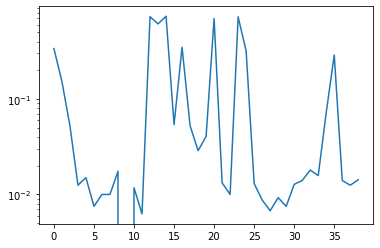

In [589]:
plt.semilogy(sers_avg)

In [344]:
x_tilde = x_tilde_re[:K] + 1j * x_tilde_re[K:]
x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
x_det_first_stage, x[:K] + 1j * x[K:]

(array([[-0.70710678-0.70710678j],
        [-0.70710678-0.70710678j]]),
 array([[-0.70710678+0.70710678j],
        [ 0.70710678+0.70710678j]]))

In [ ]:
K = 4   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = 10 # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, y):
    """
    Real representation of complex matrix \n
    \t x = [x_r + j x_i] --->  x_re = [x_re x_im] \n
    \t H_re = \n \t \t[H_real, -H_imag \n
        \t H_imag, H_real]\n
    
    """
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    y_re = np.hstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

snr = 5

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

r = np.matmul(H, x) + (10**(-snr/20)) * z  

# 1-bit ADC 
y = np.sign(r.real) + 1j * np.sign(r.imag) 

H_re, x_re, z_re, y_re = comp2re(H, x, z, y)